In [ ]:
# I had to find the right version of pytorch with the widget here https://pytorch.org/
# I *think* this will work with AWS
!pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio==0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [ ]:
# other dependencies
!pip install scikit-image timm wandb ipywidgets

### 1 Import the kitchen sink

In [77]:
# humbug main imports

import os
import pandas as pd
import sys
sys.path.insert(0, os.path.abspath('../lib'))
import config
from evaluate import get_results
import numpy as np

# Troubleshooting and visualisation
import IPython.display as ipd


In [24]:
# humbug lib imports
from sklearn.metrics import accuracy_score
import skimage.util
from PyTorch import config_pytorch
from datetime import datetime
import math
import pickle

from PyTorch.ResNetDropoutSource import resnet50dropout, resnet18
from PyTorch.vggish.vggish import VGGish
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score
import config
from datetime import datetime
import os
import librosa

import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import average_precision_score
import sys

from tqdm.notebook import tqdm

In [25]:
# additional pytorch tools
import random
import torchaudio
import torchaudio.transforms as T
import torchvision.transforms as VT
from torch.cuda.amp import autocast, GradScaler
from timm.scheduler.cosine_lr import CosineLRScheduler
import timm

# weights and biases
import wandb

### Run all these function definition cells
These have been extracted from the lib folder and are here to make them more easily editable.  Most of the action happens in *get_feat_torch*, which does feature extraction and *train_model*

In [28]:
def evaluate_model(model, X_test, y_test, n_samples, n_channels=3):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f'Evaluating on {device}')

    x_test = torch.tensor(X_test).float()
    if n_channels == 3:
        x_test = x_test.repeat(1,3,1,1)

    y_test = torch.tensor(y_test).float()
    test_dataset = TensorDataset(x_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    y_preds_all = np.zeros([n_samples, len(y_test), 2])
    model.eval() # Important to not leak info from batch norm layers and cause other issues

    for n in tqdm(range(n_samples)):
        all_y_pred = []
        all_y = []
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)

            y_pred = model(VT.Resize((224,224))(x)).squeeze()
            all_y.append(y.cpu().detach())

            all_y_pred.append(y_pred.cpu().detach())

            del x
            del y
            del y_pred

        all_y_pred = torch.cat(all_y_pred)
        all_y = torch.cat(all_y)

        y_preds_all[n,:,1] = np.array(all_y_pred)
        y_preds_all[n,:,0] = 1-np.array(all_y_pred) # Check ordering of classes (yes/no)
        test_acc = accuracy_score(all_y.numpy(), (all_y_pred.numpy() > 0.5).astype(float))
        # print(test_acc)
    return y_preds_all

In [30]:
def load_model(filepath, model):
    # Instantiate model to inspect
    device = torch.device('cuda:0' if torch.cuda.is_available() else torch.device("cpu"))
    print(f'Training on {device}')
        
    if torch.cuda.device_count() > 1:
        print("Using data parallel")
        model = nn.DataParallel(model, device_ids=list(range(torch.cuda.device_count())))
    model = model.to(device)
    # Load trained parameters from checkpoint (may need to download from S3 first)


    if torch.cuda.is_available():
        map_location=lambda storage, loc: storage.cuda()
    else:
        map_location='cpu'
        
    checkpoint = model.load_state_dict(torch.load(filepath))

    return model

In [32]:
def test_model(model, test_loader, criterion, class_threshold=0.5, device=None):
    with torch.no_grad():
        if device is None:
            torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        
        test_loss = 0.0
        model.eval()
        
        all_y = []
        all_y_pred = []
        counter = 1
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            
            y_pred = model(VT.Resize((224,224))(x)).squeeze()
            
            loss = criterion(y_pred, y)

            test_loss += loss.item()
            
            all_y.append(y.cpu().detach())
            all_y_pred.append(y_pred.cpu().detach())
            
            del x
            del y
            del y_pred
            
            counter +=1

        all_y = torch.cat(all_y)
        all_y_pred = torch.cat(all_y_pred)
        
        test_loss = test_loss/len(test_loader)
        test_acc = accuracy_score(all_y.numpy(), (all_y_pred.numpy() > class_threshold).astype(float))
    
    
    return test_loss, test_acc

In [33]:
def _get_sample(path, resample=None):
    effects = [
        ["remix", "1"]
    ]
    if resample:
        effects.extend([
          ["lowpass", f"{resample // 2}"],
          ["rate", f'{resample}'],
        ])
    return torchaudio.sox_effects.apply_effects_file(path, effects=effects)

In [36]:
def reshape_feat(feats, labels, win_size, step_size):
    '''Reshaping features from get_feat to be compatible for classifiers expecting a 2D slice as input. Parameter `win_size` is 
    given in number of feature windows (in librosa this is the hop length divided by the sample rate.)
    Can code to be a function of time and hop length instead in future.'''
    
    feats_windowed_array = []
    labels_windowed_array = []
    for idx, feat in enumerate(feats):
        if np.shape(feat)[1] < win_size:
            print('Length of recording shorter than supplied window size.') 
            pass
        else:
            feats_windowed = skimage.util.view_as_windows(feat.T, (win_size,np.shape(feat)[0]), step=step_size)
            labels_windowed = np.full(len(feats_windowed), labels[idx])
            feats_windowed_array.append(feats_windowed)
            labels_windowed_array.append(labels_windowed)
    return np.vstack(feats_windowed_array), np.hstack(labels_windowed_array)

In [35]:
def build_dataloader(x_train, y_train, x_val=None, y_val=None, shuffle=True, n_channels=1):
    x_train = torch.tensor(x_train).float()
    if n_channels == 3:
        x_train = x_train.repeat(1,3,1,1)  # Repeat across 3 channels to match ResNet pre-trained model expectation
    y_train = torch.tensor(y_train).float()
    train_dataset = TensorDataset(x_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=config_pytorch.batch_size, shuffle=shuffle)
    
    if x_val is not None:
        x_val = torch.tensor(x_val).float()
        if n_channels == 3:
            x_val = x_val.repeat(1,3,1,1)
        y_val = torch.tensor(y_val).float()
        val_dataset = TensorDataset(x_val, y_val)
        val_loader = DataLoader(val_dataset, batch_size=config_pytorch.batch_size, shuffle=shuffle)

        return train_loader, val_loader
    return train_loader

In [34]:
def get_train_test_from_df(df_train, df_test_A, df_test_B, pickle_name=None, debug=False, feat_fn=get_feat_torch):
    
    if not pickle_name:
        pickle_name_train = 'log_mel_feat_train_'+str(config.n_feat)+'_win_'+str(config.win_size)+'_step_'+str(config.step_size)+'_norm_'+str(config.norm_per_sample)+'.pickle'
         # step = window for test (no augmentation of test):
        pickle_name_test = 'log_mel_feat_test_'+str(config.n_feat)+'_win_'+str(config.win_size)+'_step_'+str(config.win_size)+'_norm_'+str(config.norm_per_sample)+'.pickle'
    else:
        pickle_name_train = f'{pickle_name}_train.pkl'
        pickle_name_test = f'{pickle_name}_test.pkl'
    
    
    if not os.path.isfile(os.path.join(config.dir_out_MED, pickle_name_train)):
        print('Extracting training features...')
        X_train, y_train, skipped_files_train, bugs_train = feat_fn(data_df=df_train, data_dir = config.data_dir,
                                                                     rate=config.rate, min_duration=config.min_duration,
                                                                     n_feat=config.n_feat, test=False)
        #X_train, y_train = reshape_feat(X_train, y_train, config.win_size, config.step_size)

        log_mel_feat_train = {'X_train':X_train, 'y_train':y_train, 'bugs_train':bugs_train}

        if debug:
            print('Bugs train', bugs_train)
        
        with open(os.path.join(config.dir_out_MED, pickle_name_train), 'wb') as f:
            pickle.dump(log_mel_feat_train, f, protocol=4)
            print('Saved features to:', os.path.join(config.dir_out_MED, pickle_name_train))

    else:
        print('Loading training features found at:', os.path.join(config.dir_out_MED, pickle_name_train))
        with open(os.path.join(config.dir_out_MED, pickle_name_train), 'rb') as input_file:
            log_mel_feat = pickle.load(input_file)
            X_train = log_mel_feat['X_train']
            y_train = log_mel_feat['y_train']

    if not os.path.isfile(os.path.join(config.dir_out_MED, pickle_name_test)):
        print('Extracting test features...')

        X_test_A, y_test_A, skipped_files_test_A, bugs_test_A = feat_fn(data_df= df_test_A, data_dir = config.data_dir,
                                                                         rate=config.rate, min_duration=config.min_duration,
                                                                         n_feat=config.n_feat, test=True)
        X_test_B, y_test_B, skipped_files_test_B, bugs_test_B = feat_fn(data_df= df_test_B, data_dir = config.data_dir,
                                                                         rate=config.rate, min_duration=config.min_duration,
                                                                         n_feat=config.n_feat, test=True)
        #X_test_A, y_test_A = reshape_feat(X_test_A, y_test_A, config.win_size, config.win_size)  # Test should be strided with step = window.
        #X_test_B, y_test_B = reshape_feat(X_test_B, y_test_B, config.win_size, config.win_size)  
        
        log_mel_feat_test = {'X_test_A':X_test_A, 'X_test_B':X_test_B, 'y_test_A':y_test_A, 'y_test_B':y_test_B}

        if debug:
            print('Bugs test A', bugs_test_A)
            print('Bugs test B', bugs_test_B)

        
        with open(os.path.join(config.dir_out_MED, pickle_name_test), 'wb') as f:
            pickle.dump(log_mel_feat_test, f, protocol=4)
            print('Saved features to:', os.path.join(config.dir_out_MED, pickle_name_test))
    else:
        print('Loading test features found at:', os.path.join(config.dir_out_MED, pickle_name_test))
        with open(os.path.join(config.dir_out_MED, pickle_name_test), 'rb') as input_file:
            log_mel_feat = pickle.load(input_file)

            X_test_A = log_mel_feat['X_test_A']
            y_test_A = log_mel_feat['y_test_A']
            X_test_B = log_mel_feat['X_test_B']
            y_test_B = log_mel_feat['y_test_B']


    return X_train, y_train, X_test_A, y_test_A, X_test_B, y_test_B

In [66]:
def train_model(x_train, y_train, x_val=None, y_val=None, model = None, n_channels = 1):
    # Creates a GradScaler once at the beginning of training.
    scaler = GradScaler()
    global_step = 0
    if x_val is not None:  # TODO: check dimensions when supplying validation data.
        train_loader, val_loader = build_dataloader(x_train, y_train, x_val, y_val, n_channels = n_channels)
    
    else:
        train_loader = build_dataloader(x_train, y_train, n_channels = n_channels)

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#     device = 'cpu'
    print(f'Training on {device}')

    
    
    if torch.cuda.device_count() > 1:
        print("Using data parallel")
        model = nn.DataParallel(model, device_ids=list(range(torch.cuda.device_count())))

    model = model.to(device)

    # Change compatibility to other loss function, cross-test with main.
    #criterion = nn.BCEWithLogitsLoss()
    criterion = nn.BCEWithLogitsLoss()
    optimiser = optim.Adam(model.parameters(), lr=config_pytorch.lr)
    
    num_steps = len(train_loader)
    num_epochs = config_pytorch.epochs
    
    
    # 2 cycle CosineLR
    scheduler = CosineLRScheduler(
            optimiser,
            t_initial= num_steps * (num_epochs // 2) + 1,
            lr_min=5e-4,
            warmup_lr_init=5e-4,
            warmup_t= num_steps * config_pytorch.n_warmup_epochs + 1)
    


    all_train_loss = []
    all_train_acc = []
    all_val_loss = []
    all_val_acc = []
    best_val_loss = np.inf
    best_val_acc = -np.inf

    # best_train_loss = np.inf
    best_train_acc = -np.inf

    best_epoch = -1
    checkpoint_name = None
    overrun_counter = 0

    # Magic
    wandb.watch(model, log_freq=100)
    
    for e in range(config_pytorch.epochs):
        train_loss = 0.0
        model.train()
        running_loss = 0.0
        all_y = []
        all_y_pred = []
        tk0 = tqdm(train_loader, total=int(len(train_loader)))
        for batch_i, inputs in enumerate(tk0):
            scheduler.step(global_step)
            ##Necessary in order to handle single and multi input feature spaces
            x = [xi.to(device).detach() for xi in inputs[:-1]]
            y = inputs[-1].to(device).detach().view(-1,1)
            global_step += 1
            
            if len(x) == 1:
                x = x[0]

            optimiser.zero_grad()
            # AMP
            with autocast():
                # outputs = model(inputs)
                y_pred = model(VT.Resize((224,224))(x))
                # loss = criterion(outputs, labels)
                loss = criterion(y_pred, y)
            # y_pred = model(T.Resize((224,224))(x))
#             print(T.Resize((224,224))(x).shape)
#             print(y_pred)
#             print(y)
            # loss = criterion(y_pred, y)
    
            scaler.scale(loss).backward()
            scaler.step(optimiser)
          # Updates the scale for next iteration.
            scaler.update()

#             loss.backward()
#             optimiser.step()
            
            

            train_loss += loss.item()
            all_y.append(y.cpu().detach())
            all_y_pred.append(y_pred.cpu().detach())
            
            tk0.set_postfix(training_loss=(train_loss / (batch_i+1)))
            
            wandb.log({'loss': (train_loss / (batch_i+1))})

            del x
            del y

        all_train_loss.append(train_loss/len(train_loader))

        all_y = torch.cat(all_y)
        all_y_pred = torch.cat(all_y_pred)
        train_acc = accuracy_score(all_y.numpy(), (all_y_pred.numpy() > 0.5).astype(float))
        all_train_acc.append(train_acc)


        # Can add more conditions to support loss instead of accuracy. Use *-1 for loss inequality instead of acc
        if x_val is not None:
            val_loss, val_acc = test_model(model, val_loader, criterion, 0.5, device=device)
            all_val_loss.append(val_loss)
            all_val_acc.append(val_acc)

            acc_metric = val_acc
            best_acc_metric = best_val_acc
        else:
            acc_metric = train_acc
            best_acc_metric = best_train_acc
        if acc_metric > best_acc_metric:  
            # if checkpoint_name is not None:
                # os.path.join(os.path.pardir, 'models', 'pytorch', checkpoint_name)

            checkpoint_name = f'model_e{e}_{datetime.now().strftime("%Y_%m_%d_%H_%M_%S")}.pth'

            torch.save(model.state_dict(), os.path.join(config.model_dir, 'pytorch', checkpoint_name))
            print('Saving model to:', os.path.join(config.model_dir, 'pytorch', checkpoint_name)) 
            best_epoch = e
            best_train_acc = train_acc
            best_train_loss = train_loss
            if x_val is not None:
                best_val_acc = val_acc
                best_val_loss = val_loss
            overrun_counter = -1

        overrun_counter += 1
        if x_val is not None:
            print('Epoch: %d, Train Loss: %.8f, Train Acc: %.8f, Val Loss: %.8f, Val Acc: %.8f, overrun_counter %i' % (e, train_loss/len(train_loader), train_acc, val_loss/len(val_loader), val_acc,  overrun_counter))
        else:
            print('Epoch: %d, Train Loss: %.8f, Train Acc: %.8f, overrun_counter %i' % (e, train_loss/len(train_loader), train_acc, overrun_counter))
        if overrun_counter > config_pytorch.max_overrun:
            break
    return model

In [27]:
def get_feat_torch(data_df, data_dir, rate, min_duration, n_feat, test=False):
    ''' Returns features extracted with Librosa. A list of features, with the number of items equal to the number of input recordings'''
    X = []
    y = []
    bugs = []
    idx = 0
    resample_rate = 8000
    n_fft=1024
    n_mels=128
    hop_length = 512
    n_mfcc = 128
    gain          = 0.3
    bias          = 0.2
    power         = 0.6
    time_constant = 0.9
    eps           = 1e-9
    # -----
    m_spectrogram = T.MelSpectrogram(
        n_fft=n_fft,
    #     win_length=win_length,
        #hop_length=hop_length,
        center=True,
    #     pad_mode="reflect",
        power=1.0,
        norm=None,
        onesided=True,
        n_mels=n_mels,
        mel_scale="htk",
        normalized=False
    )
    # ----
    skipped_files = []
    for row_idx_series in data_df.iterrows():
        idx+=1
        if idx % 100 == 0:
            print('Completed', idx, 'of', len(data_df))
        row = row_idx_series[1]
        label_duration = row['length']
        if label_duration > min_duration:
            _, file_format = os.path.splitext(row['name'])
            filename = os.path.join(data_dir, str(row['id']) + file_format)
            length = librosa.get_duration(filename = filename)
#             assert math.isclose(length,label_duration, rel_tol=0.01), "File: %s label duration (%.4f) does not match audio length (%.4f)" % (row['path'], label_duration, length)
            
            if math.isclose(length,label_duration, rel_tol=0.01):
                waveform, _ = _get_sample(filename, resample=resample_rate)
                
                # first get regular spectrogram
                feat = m_spectrogram(waveform)
                feat = librosa.core.pcen(feat.numpy(), 
                                 sr            = resample_rate,
#                                  hop_length    = hop_length,
                                 gain          = gain,
                                 bias          = bias,
                                 power         = power,
                                 time_constant = time_constant,
                                 eps           = eps)
                X.append(feat)
                y.append(1) if row['sound_type'] == 'mosquito' else y.append(0)
                
                if not test:
                    #if row['sound_type'] == 'mosquito':
                    # then add some noise
                    noise_row = data_df[(data_df['sound_type']!='mosquito') & (data_df['length'] >= row['length'])].sample(1).iloc[0]
                    _, file_format = os.path.splitext(noise_row['name'])
                    filename = os.path.join(data_dir, str(noise_row['id']) + file_format)
                    noise, _= _get_sample(filename, resample=resample_rate)

                    noise = noise[:, :waveform.shape[1]]

                    mos_power = waveform.norm(p=2)
                    noise_power = noise.norm(p=2)
                    
                    random.randrange(-50, -5)
                    
                    snr = math.exp(random.randrange(3, 15) / 10)
                    scale = snr * noise_power / mos_power
                    noisy_speech = (scale * waveform + noise) / 2

                    feat = m_spectrogram(noisy_speech)
                    feat = librosa.core.pcen(feat.numpy(), 
                                 sr            = resample_rate,
#                                  hop_length    = hop_length,
                                 gain          = gain,
                                 bias          = bias,
                                 power         = power,
                                 time_constant = time_constant,
                                 eps           = eps)
                    X.append(feat)
                    y.append(1) if row['sound_type'] == 'mosquito' else y.append(0)
                
            else:
                print("File: %s label duration (%.4f) does not match audio length (%.4f)" % (row['name'], label_duration, length))
                bugs.append([row['name'], label_duration, length])
                
        else:
            skipped_files.append([row['id'], row['name'], label_duration])
            
    print('x',len(X),len(y))
#    print('y',y[0].shape)
    
    if test:
        X = [x[0] for x in X]
    else:
        masking = T.TimeMasking(time_mask_param=12,)
        X2 = [masking(torch.tensor(x).float()) for x in X]
        
        masking = T.FrequencyMasking(freq_mask_param=50)
        X3 = [masking(torch.tensor(x).float()) for x in X]

        print(X2[0].shape)
        X = [x[0] for x in X]+[x[0].numpy() for x in X2]+[x[0].numpy() for x in X3]
        y = y+y.copy()+y.copy()
        print(X[0].shape)
        print(X[-1].shape)
    
    X, y = reshape_feat(X, y, config.win_size*2, config.step_size*2)
#        X, y = reshape_feat(X, y, config.win_size, config.step_size)
    
    return X, y, skipped_files, bugs

### 3 The Data

### Read CSV and get train/test groups

In [37]:
df = pd.read_csv(config.data_df)

# To be kept: please do not edit the test set: these paths select test set A, test set B as described in the paper
idx_test_A = np.logical_and(df['country'] == 'Tanzania', df['location_type'] == 'field')
idx_test_B = np.logical_and(df['country'] == 'UK', df['location_type'] == 'culture')
idx_train = np.logical_not(np.logical_or(idx_test_A, idx_test_B))
df_test_A = df[idx_test_A]
df_test_B = df[idx_test_B]


df_train = df[idx_train]

# Modify by addition or sub-sampling of df_train here
# df_train ... 

# Assertion to check that train does NOT appear in test:
assert len(np.where(pd.concat([df_train,df_test_A,
                               df_test_B]).duplicated())[0]) == 0, 'Train dataframe contains overlap with Test A, Test B'

The does the feature extraction.  Set the pickle name to a unique value and pass in the feature extractor as the feat_fn function if using a different one.

In [40]:
%%time
X_train, y_train, X_test_A, y_test_A, X_test_B, y_test_B = \
    get_train_test_from_df(df_train, df_test_A, df_test_B, 
                           pickle_name='feat_torch_pcen_TFM_1024', debug=False, 
                           feat_fn=get_feat_torch)

Extracting training features...
Completed 100 of 7934
Completed 200 of 7934
Completed 300 of 7934
Completed 400 of 7934
Completed 500 of 7934
Completed 600 of 7934
Completed 700 of 7934
Completed 800 of 7934
Completed 900 of 7934
Completed 1000 of 7934
Completed 1100 of 7934
Completed 1200 of 7934
Completed 1300 of 7934
Completed 1400 of 7934
Completed 1500 of 7934
Completed 1600 of 7934
Completed 1700 of 7934
Completed 1800 of 7934
Completed 1900 of 7934
Completed 2000 of 7934
Completed 2100 of 7934
Completed 2200 of 7934
Completed 2300 of 7934
Completed 2400 of 7934
Completed 2500 of 7934
Completed 2600 of 7934
Completed 2700 of 7934
Completed 2800 of 7934
Completed 2900 of 7934
Completed 3000 of 7934
Completed 3100 of 7934
Completed 3200 of 7934
Completed 3300 of 7934
Completed 3400 of 7934
Completed 3500 of 7934
Completed 3600 of 7934
Completed 3700 of 7934
Completed 3800 of 7934
Completed 3900 of 7934
Completed 4000 of 7934
Completed 4100 of 7934
Completed 4200 of 7934
Completed 4

In [41]:
# sanity check output shape
X_train.shape

(805470, 1, 60, 128)

In [42]:
# train/val spilt
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [43]:
len(X_train), len(X_val)

(644376, 161094)

### 4 Training

In [73]:
# Subclass the pretrained model and make it a binary classification

class Model(nn.Module):
    def __init__(self, model_name):
        super().__init__()
        # num_classes=0 removes the pretrained head
        self.backbone = timm.create_model(model_name,
                        pretrained=True, num_classes=0, drop_path_rate=0.2)
        #####  This section is model specific
        #### It freezes some fo the layers by name
        #### you'll have to inspect the model to see the names
        for name, param in self.backbone.named_parameters():
            if param.requires_grad and 'head' not in name \
                and not name.startswith('norm') \
                and 'layer4' not in name:
                param.requires_grad = False
        #### end layer freezing        
        self.out = nn.Linear(self.backbone.num_features, 1)
        
    def forward(self, x):
        x = self.backbone(x)
        return self.out(x)

In [74]:
# Weights and biases integration is in progress
# but it'll make pretty graphs for status updates

wandb_config = dict (
  filters = 'PCEN',
  augmentation = 'time mask, noise, frequency mask',
  n_fft = '1024',
  architecture = "ig_resnext101_32x16d",
  feature_set = 'B',
  unfrozen_layers = "layer4",
)

wandb.init(
  project="VectNet",
  config=wandb_config,
)

In [54]:
## run this cell to list pretrained models
avail_pretrained_models = timm.list_models(pretrained=True)
avail_pretrained_models

['adv_inception_v3',
 'bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_224_in22k',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_224_in22k',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'botnet26t_256',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'convit_base',
 'convit_small',
 'convit_tiny',
 'convmixer_768_32',
 'convmixer_1024_20_ks9_p14',
 'convmixer_1536_20',
 'convnext_base',
 'convnext_base_384_in22ft1k',
 'convnext_base_in22ft1k',
 'convnext_base_in22k',
 'convnext_large',
 'convnext_large_384_in22ft1k',
 'convnext_large_in22ft1k',
 'convnext_large_in22k',
 'convnext_small',
 'convnext_tiny',
 'convnext_xlarge_384_in22ft1k',
 'convnext_xlarge_in22ft1k',
 'convnext_xlarge_in22k',
 'crossvit_9_240',
 'crossv

In [75]:
## put a model name in here to downlad a pretrained model and convert it
## to binary classification
pt_model = Model('ig_resnext101_32x16d')

In [72]:
# look at layer names to figure out what to freeze
# You'll have to go edit the Model class and reload it based 
# on the model names you're freezing here
[name for name, _ in pt_model.named_parameters()]

['backbone.conv1.weight',
 'backbone.bn1.weight',
 'backbone.bn1.bias',
 'backbone.layer1.0.conv1.weight',
 'backbone.layer1.0.bn1.weight',
 'backbone.layer1.0.bn1.bias',
 'backbone.layer1.0.conv2.weight',
 'backbone.layer1.0.bn2.weight',
 'backbone.layer1.0.bn2.bias',
 'backbone.layer1.0.conv3.weight',
 'backbone.layer1.0.bn3.weight',
 'backbone.layer1.0.bn3.bias',
 'backbone.layer1.0.downsample.0.weight',
 'backbone.layer1.0.downsample.1.weight',
 'backbone.layer1.0.downsample.1.bias',
 'backbone.layer1.1.conv1.weight',
 'backbone.layer1.1.bn1.weight',
 'backbone.layer1.1.bn1.bias',
 'backbone.layer1.1.conv2.weight',
 'backbone.layer1.1.bn2.weight',
 'backbone.layer1.1.bn2.bias',
 'backbone.layer1.1.conv3.weight',
 'backbone.layer1.1.bn3.weight',
 'backbone.layer1.1.bn3.bias',
 'backbone.layer1.2.conv1.weight',
 'backbone.layer1.2.bn1.weight',
 'backbone.layer1.2.bn1.bias',
 'backbone.layer1.2.conv2.weight',
 'backbone.layer1.2.bn2.weight',
 'backbone.layer1.2.bn2.bias',
 'backbone.l

In [ ]:
model = train_model(X_train, y_train, X_val, y_val, model=pt_model, n_channels=3)

In [63]:
# path and model name are used to save the PDF output
# but loading the model isn't needed unless the notebook
# has been restarted.  This will be replaced by
# weights and biases soon
path = '../outputs/models/pytorch/'
model_name = 'model_e18_2022_02_11_16_37_49.pth'

#model = load_model(path + model_name, pt_model)
model = pt_model

### Test B evaluation

Evaluating on cuda:0


  0%|          | 0/1 [00:00<?, ?it/s]

/my_data/UCB/W210/HumBugDB/lib/evaluate.py:26: RuntimeWarning: invalid value encountered in log
  G_X, U_X, log_prob = active_BALD(np.log(out), y_test, 2)


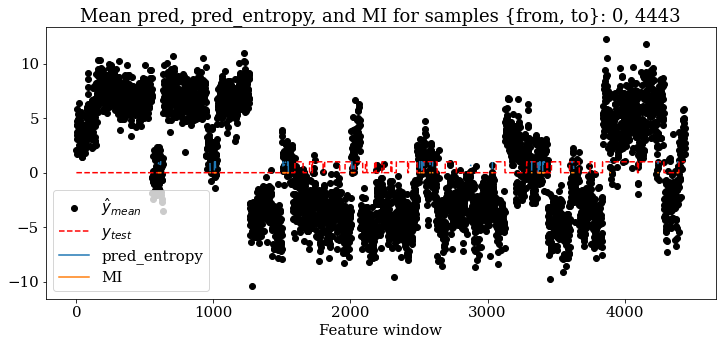

mean ROC AUC: 0.4190745748318323


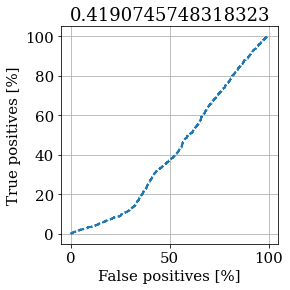

std ROC AUC: 0.0
PR-AUC:  0.28950635277741354


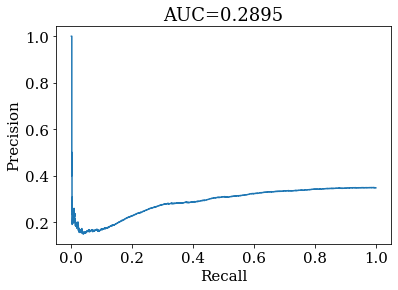

Confusion matrix, as input by user
[[48.3103 51.6897]
 [61.3091 38.6909]]


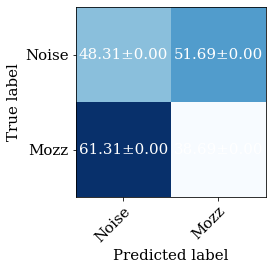

In [64]:
## feat_type is a unique name for the combination of paramters and pre-processing
## will get replaced with W&X
feat_type = 'feat_torch_hrnet_w32_1024_tfm'

y_preds_all = evaluate_model(model, X_test_B, y_test_B, 1, n_channels=3)  # Predict directly over feature windows (1.92 s)

PE, MI, log_prob = get_results(y_preds_all, y_test_B, filename = feat_type + '_' + model_name +'_Test_B')

### Test A

Evaluating on cuda:0


  0%|          | 0/1 [00:00<?, ?it/s]

/my_data/UCB/W210/HumBugDB/lib/evaluate.py:26: RuntimeWarning: invalid value encountered in log
  G_X, U_X, log_prob = active_BALD(np.log(out), y_test, 2)


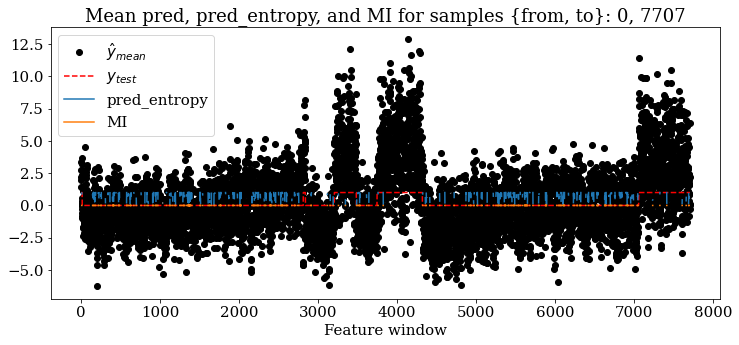

mean ROC AUC: 0.8940362470454208


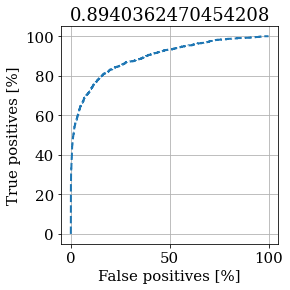

std ROC AUC: 0.0
PR-AUC:  0.7891611069157934


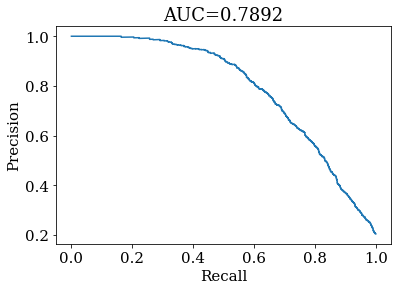

Confusion matrix, as input by user
[[71.468  28.532 ]
 [12.9702 87.0298]]


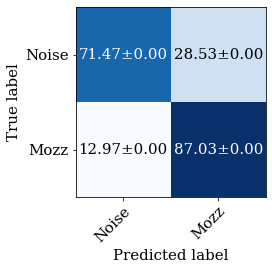

In [65]:
y_preds_all = evaluate_model(model, X_test_A, y_test_A, 1)  # Predict directly over feature windows (1.92 s)
PE, MI, log_prob = get_results(y_preds_all, y_test_A, filename = feat_type + '_' + model_name +'_Test_A')

In [ ]:
for e in range(config_pytorch.epochs):
        train_loss = 0.0
        model.train()

        all_y = []
        all_y_pred = []
        
        for idx,(x,y) in enumerate(train_loader):

            ##Necessary in order to handle single and multi input feature spaces
            
            
            bat_size = x.shape[0]
            #print(bat_size)
            #print(x.shape)
            time_dim = x.shape[2]
            freq_dim = x.shape[3]
            #print("time_dim = " +str(time_dim))
            #print("Freq_dim = " +str(freq_dim))
            #here you'll send it to model 
            x_reshaped = x.reshape(bat_size,time_dim,freq_dim)
            #print(x_reshaped.shape)
            
            #x = [xi.to(device).detach() for xi in inputs[:-1]]
            #y = inputs[-1].to(device).detach().view(-1,1)

            if len(x) == 1:
                x = x[0]

            optimiser.zero_grad()
            y_pred = model(x_reshaped)
            loss = criterion(y_pred, y)

            loss.backward()
            optimiser.step()

            train_loss += loss.item()
            all_y.append(y)
            all_y_pred.append(y_pred)

            del x
            del y

        all_train_loss.append(train_loss/len(train_loader))

        all_y = torch.cat(all_y)
        all_y_pred = torch.cat(all_y_pred)
        train_acc = accuracy_score(all_y.numpy(), (all_y_pred.numpy() > 0.5).astype(float))
        all_train_acc.append(train_acc)


        # Can add more conditions to support loss instead of accuracy. Use *-1 for loss inequality instead of acc
        if x_val is not None:
            val_loss, val_acc = test_model(model, val_loader, criterion, 0.5, device=device)
            all_val_loss.append(val_loss)
            all_val_acc.append(val_acc)

            acc_metric = val_acc
            best_acc_metric = best_val_acc
        else:
            acc_metric = train_acc
            best_acc_metric = best_train_acc
        if acc_metric > best_acc_metric:  
            # if checkpoint_name is not None:
                # os.path.join(os.path.pardir, 'models', 'pytorch', checkpoint_name)

            checkpoint_name = f'model_e{e}_{datetime.now().strftime("%Y_%m_%d_%H_%M_%S")}.pth'

            torch.save(model.state_dict(), os.path.join(config.model_dir, 'pytorch', checkpoint_name))
            print('Saving model to:', os.path.join(config.model_dir, 'pytorch', checkpoint_name)) 
            best_epoch = e
            best_train_acc = train_acc
            best_train_loss = train_loss
            if x_val is not None:
                best_val_acc = val_acc
                best_val_loss = val_loss
            overrun_counter = -1

        overrun_counter += 1
        if x_val is not None:
            print('Epoch: %d, Train Loss: %.8f, Train Acc: %.8f, Val Loss: %.8f, Val Acc: %.8f, overrun_counter %i' % (e, train_loss/len(train_loader), train_acc, val_loss/len(val_loader), val_acc,  overrun_counter))
        else:
            print('Epoch: %d, Train Loss: %.8f, Train Acc: %.8f, overrun_counter %i' % (e, train_loss/len(train_loader), train_acc, overrun_counter))
        if overrun_counter > config_pytorch.max_overrun:
            break
    return model